<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/vgg19_CNN_transfer_learning_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import History 
from keras.models import Sequential
from tensorflow.keras import layers

from random import randint
import numpy as np
import os
from tqdm import tqdm

from skimage.io import imread
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

# Making the dataset:

In [ ]:
# read all the images first
x_train = []
WIDTH = 128
for i in range(1, 4): # changed to 3 classes
    base_dir = f'./cancer_dataG/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        resized = cv2.resize(img, (WIDTH, WIDTH))
        x_train.append(resized)
X_train = np.array(x_train)
X_train.shape

100%|██████████| 250/250 [00:00<00:00, 355.74it/s]


(750, 128, 128)

In [ ]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

## Labels to categorical

In [ ]:
from tensorflow.keras.utils import to_categorical

print(Y_train.shape)

Y_train =to_categorical(Y_train)

print(Y_train.shape)

(750,)
(750, 3)


## Normalize dataset:

In [ ]:
print('Maximum before: ', np.max(X_train))
print('Mean before: ', np.mean(X_train), end='\n\n')

X_train = X_train / 255

print('Maximum after: ', np.max(X_train))
print('Mean after: ', np.mean(X_train))

Maximum before:  255
Mean before:  44.361420817057294

Maximum after:  1.0
Mean after:  0.17396635614532258


## Splitting the data:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,
                                                    stratify=Y_train, 
                                                    test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(600, 128, 128)
(150, 128, 128)


In [ ]:
# Reshaping as per requirement

x_wanted_train = x_train.reshape(len(x_train), WIDTH, WIDTH, 1)
x_wanted_test = x_test.reshape(len(x_test), WIDTH, WIDTH, 1)

## Augmenting the data:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
datagen.fit(x_wanted_train)

# Model Work: 

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
# Adding some extra layers before the input to deal with a single channel image
# vgg takes a 3 channel input
img_input = layers.Input(shape=(WIDTH, WIDTH, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

# Load model without classifier/fully connected layers
# the top 3 layers are the fully connected dense layers when we say include_top = False
# it means we don't want them, we only want the Convolutional layers
VGG_model = VGG19(input_tensor=img_conc, weights='imagenet', include_top=False)

In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

In [ ]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 3)  0           input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        concatenate_1[0][0]              
______________________________________________________________________________________________

## Creating the model:

In [ ]:
INPUT_SHAPE = (WIDTH, WIDTH)   

model = Sequential()
# to add the extra dimesion in the image
#model.add(layers.Reshape((WIDTH, WIDTH, 1), input_shape=INPUT_SHAPE))
# using the vgg-16 CNN with learned features, no learning now
model.add(VGG_model)
# flattening the multiple dimension output from the CNN
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(CLASSES, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 22,122,563
Trainable params: 2,098,179
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])

## Training the model

In [ ]:
history = model.fit(datagen.flow(x_wanted_train, y_train, batch_size=32,
         subset='training'),
         validation_data=datagen.flow(x_wanted_test, y_test,
         batch_size=8, subset='validation'),
#          steps_per_epoch=len(x_train) // 32, 
#         validation_steps = len(x_train) // 8,
        epochs=10)

Epoch 1/10
15/15 [==============================] - 22s 1s/step - loss: 2.9082 - accuracy: 0.4958 - val_loss: 2.6433 - val_accuracy: 0.4000
Epoch 2/10
15/15 [==============================] - 22s 1s/step - loss: 0.7389 - accuracy: 0.7188 - val_loss: 0.6486 - val_accuracy: 0.6667
Epoch 3/10
15/15 [==============================] - 36s 2s/step - loss: 0.5543 - accuracy: 0.7625 - val_loss: 0.1558 - val_accuracy: 1.0000
Epoch 4/10
15/15 [==============================] - 24s 2s/step - loss: 0.2448 - accuracy: 0.9229 - val_loss: 1.0623 - val_accuracy: 0.6667
Epoch 5/10
15/15 [==============================] - 21s 1s/step - loss: 0.3308 - accuracy: 0.8687 - val_loss: 0.1723 - val_accuracy: 0.9667
Epoch 6/10
15/15 [==============================] - 22s 1s/step - loss: 0.1188 - accuracy: 0.9625 - val_loss: 0.0684 - val_accuracy: 1.0000
Epoch 7/10
15/15 [==============================] - 51s 3s/step - loss: 0.2225 - accuracy: 0.9167 - val_loss: 0.4739 - val_accuracy: 0.8333
Epoch 8/10
15/15 [==

## Visualizing Results:

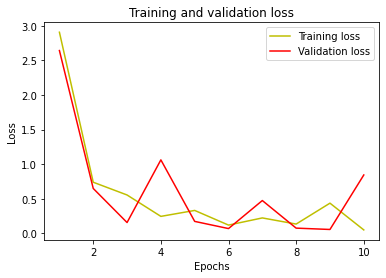

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

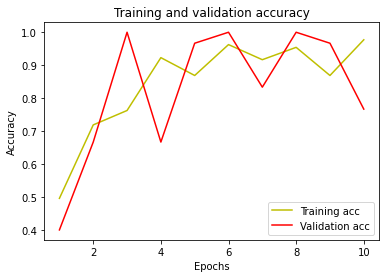

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Taking a prediction:

The prediction for this image is:  1
The actual label for this image is:  1


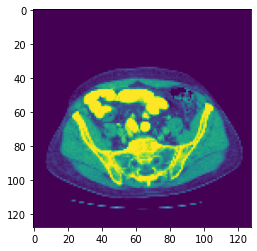

In [ ]:
n = 35  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y)

print("The prediction for this image is: ", np.argmax(model.predict(input_img)[0]))
print("The actual label for this image is: ", np.argmax(y_test[n]))